In [1]:
import copy

import prody
from rdkit import Chem
from rdkit.Chem import Draw
from prody.proteins.functions import showProtein, view3D

from rgroup import rep2D, draw3D, merge_R_group

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
# load the complex with the ligand
sys = prody.parsePDB('5NEV.pdb1')
rec = sys.select('not (nucleic or hetatm) and not water')
mol = sys.select('resname 72L')

prody.writePDB('rec.pdb', rec)
# prody.writePDB('lig.pdb', mol), user should provide the ligand

@> 4485 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [3]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
!obabel lig.sdf -O ligh.sdf -p 7
# ^manually modify the files if need be

1 molecule converted


In [4]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('ligh.sdf', removeHs=False)[0]

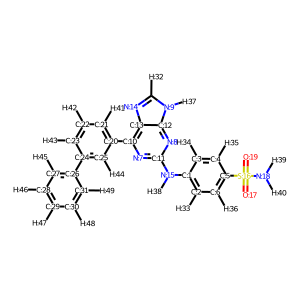

In [5]:
# select the atom to be replaced with the R group
Draw.MolToImage(rep2D(init_mol))

In [6]:
# load the R group
R_group = Chem.MolFromMolFile('data/rgroups/molecules/alcohols/propane-1_2_3-triol-r.mol', removeHs=False)
draw3D(R_group)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
rmol = merge_R_group(init_mol, R_group, 47)
rmol.draw3D()

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff3a485cb20> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff3a485ca30>


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

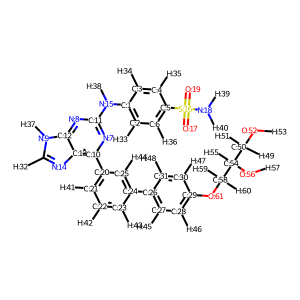

In [8]:
Draw.MolToImage(rep2D(rmol, idx=True))

RDKit ERROR: [15:46:30] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
RDKit ERROR: 
[15:46:30] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31



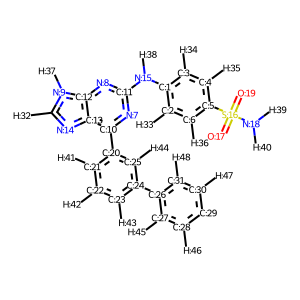

In [9]:
Draw.MolToImage(rep2D(rmol.template, idx=True))

In [10]:
toxicity = rmol.toxicity()
toxicity

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs
0,532.152889,9,5,2.8099,True,False,False


In [11]:
# visualise the template
# draw3D(rmol.template)

In [12]:
# view = rmol.draw3D()
# view.addModel(Chem.MolToMolBlock(rmol.template), 'mol')
# view

In [13]:
# present the 3D structure
base = copy.deepcopy(rmol.template)
base = Chem.AddHs(base, addCoords=True)
draw3D(base)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
rmol.generate_conformers(num_conf=20, minimum_conf_rms=0.5)

removed 1 duplicated conformations


In [15]:
match = rmol.GetSubstructMatch(rmol.template)
coordMap = {}

In [16]:
rmol.draw3Dconfs()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
t = rmol.template
for a in t.GetAtoms():
    print('temp', a.GetIdx())

temp 0
temp 1
temp 2
temp 3
temp 4
temp 5
temp 6
temp 7
temp 8
temp 9
temp 10
temp 11
temp 12
temp 13
temp 14
temp 15
temp 16
temp 17
temp 18
temp 19
temp 20
temp 21
temp 22
temp 23
temp 24
temp 25
temp 26
temp 27
temp 28
temp 29
temp 30
temp 31
temp 32
temp 33
temp 34
temp 35
temp 36
temp 37
temp 38
temp 39
temp 40
temp 41
temp 42
temp 43
temp 44
temp 45
temp 46
temp 47
temp 48


In [18]:
rmol.GetNumConformers()

20

In [19]:
# filter by the protein clashes

view = view3D(rec)
rmol.draw3Dconfs(view)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
rmol.removeConfsClashingWithProdyProt(rec)

Clash with the protein. Removing conformer id: 16
Clash with the protein. Removing conformer id: 15
Clash with the protein. Removing conformer id: 13


In [21]:
view = view3D(rec)
rmol.draw3Dconfs(view)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol